<a href="https://colab.research.google.com/github/Maytsukirp/dsp/blob/master/Mask_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%tensorflow_version 1.x

In [34]:
pip install keras==2.2.3

In [35]:
!pip install mrcnn

In [0]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import json
import matplotlib
import matplotlib.pyplot as plt
import skimage.draw
from skimage.transform import rescale, resize
#from scipy.misc import imsave
 
 
#hide warnings 
import warnings
warnings.filterwarnings('ignore')
 
# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/My Drive/Colab Notebooks/SEMINARIO/maskRCNNv2")
 
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
 
%matplotlib inline 
 
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
 
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [37]:
class FridgeConfig(Config):
  ###Configuración para entrenamiento en el conjunto de datos
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "fridge" ###nombre de la configuracion 
 
    # Train on 1 GPU and 2 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 2 (GPUs * images/GPU).
    GPU_COUNT = 1 ##Uso una GPU
    IMAGES_PER_GPU = 2  ##imagenes por GPU(IMAGENES PEQUEÑAS)
 
    # Number of classes (including background)
    NUM_CLASSES = 4 + 1 # background + 1 fridge
    # numero de clases= 1+1 (soma+background) Background siempre se coloca
 
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 320 ##limites de la imagen lardo pequeño y lado grande
    IMAGE_MAX_DIM = 320
 
    # Use smaller anchors because our image and objects are small
    #RPN_ANCHOR_SCALES = (64, 128, 256, 512)  # anchor side in pixels
    #Se define los anchor pequeños, proporcionales al tamaño de la imagen 
 
    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32 ## se definen los ROI (Region de interes) por imagen 
 
    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 500 # se define las epocas: pequeña porque los datos son simples 
 
    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 10 ## se define los pasos por epocas 
    
config = FridgeConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  320
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES

In [0]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
 
    ### Devuelva una matriz de ejes Matplotlib para usar en todas las visualizaciones del cuaderno. 
    ##Se cambia el tamaño 
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

Dataset

Crea un dataset sintetico
Se extiende las clases del dataset y se agrega un metodo para cargar el conjunto de datos y se anulan los metodos:
load_image()
load_mask()
image_reference()

In [0]:
class FridgeDataset(utils.Dataset):
 
  ### Genera el conjunto de datos sintético de formas. El conjunto de datos consta de simples
 
    def load_fridge(self, dataset_dir, subset):##clase, direccion dataset y subclase
        """Load a subset of the fridge dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        #Cargue un subconjunto del conjunto de datos.Subconjunto para cargar: entrenamiento o validacion
        # Add classes. We have only one class to add.
        self.add_class("fridge", 1, "Sin anemia")
        self.add_class("fridge", 2, "Leve")
        self.add_class("fridge", 3, "Moderada")
        self.add_class("fridge", 4, "Severa")
#        self.add_class("fridge", 5, "FridgeSide")
        
 
        # Train or validation dataset?
        assert subset in ["train", "val"] ##assert una expresion para detectar errores-siempre verdadera
        dataset_dir = os.path.join(dataset_dir, subset) ##Unir uno o más componentes de ruta de forma inteligente
 
        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region//Nos preocupamos principalmente por las coordenadas x e y de cada región
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys
 
        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.Via guarda las imagenes en JSON iincluso si no tiene ninguna anotacion 
        #Omitor las imagenes sin anotar 
        annotations = [a for a in annotations if a['regions']]
        print(len(annotations))
        b = annotations[0]
        c = b['regions']['0']
        print(c['shape_attributes'])
        
        
 
          # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions'].values()]
            classids = [r['region_attributes'] for r in a['regions'].values()]
            #polygons = [r['shape_attributes'] for r in a['regions'].values()]
            #polygons = []
            #classids = []
            class_Ids = []
            #counter = 0
            #for i in a['regions']:
            #    counter += 1
                
            
            for i, p in enumerate(classids):
                val = 0
                if p['Type'] == 'Sin anemia':
                    val = 1
                if p['Type'] == 'Leve':
                    val = 2
                if p['Type'] == 'Moderada':
                    val = 3
                if p['Type'] == 'Severa':
                    val = 4
                #if p['Class'] == 'FridgeSide':
                #    val = 5
                class_Ids.append(val)
    
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
 
            img_gris = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            padd_image = 255*np.ones((4160,3120), dtype=np.uint8)
            padd_image[:,:]=img_gris.copy()
            
 
            
            height, width = padd_image.shape[:2]
            print('Before: ', padd_image.shape[:2])
            factorscaleWidth = 320.0/width
            factorscaleHeight = 320.0/height
            image = resize(padd_image, (round(factorscaleHeight*height), round(factorscaleWidth*width)))
            
            height, width = image.shape[:2]
            a['filename'] = str('resized') + a['filename']
            image_path = os.path.join(dataset_dir,a['filename'])
            skimage.io.imsave(image_path, image)
            print('After: ', image.shape[:2])
 
            self.add_image(
                "fridge",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                factorscaleWidth=factorscaleWidth,
                factorscaleHeight=factorscaleHeight,
                catIds=class_Ids)
 
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        shapes = info['catIds']
        factorscaleWidth = info['factorscaleWidth']
        factorscaleHeight = info['factorscaleHeight']
        count = len(shapes)
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])], dtype=np.uint8)
        
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            x = p['all_points_x']
            y = p['all_points_y']
            xx = []
            yy = []
            for k in range(len(x)):
                xx.append(round(factorscaleWidth*x[k]))
            for k in range(len(y)):
                yy.append(round(factorscaleHeight*y[k]))
            #print(x)
            rr, cc = skimage.draw.polygon(yy, xx)
            mask[rr, cc, i] = 1
            
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count - 2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        
        # Map class names to class IDs.
        class_ids = np.array(shapes)
        return mask, class_ids.astype(np.int32)      
 
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "fridge":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [41]:
"""Train the model."""
# Training dataset.
dataset_train = FridgeDataset()
dataset_train.load_fridge("/content/drive/My Drive/Colab Notebooks/SEMINARIO/may", "train")
dataset_train.prepare()
 
# Validation dataset
dataset_val = FridgeDataset()
dataset_val.load_fridge("/content/drive/My Drive/Colab Notebooks/SEMINARIO/may", "val")
dataset_val.prepare()

10
{'name': 'polygon', 'all_points_x': [1073, 1158, 1267, 1466, 1669, 1803, 1774, 1535, 1292, 1073], 'all_points_y': [2360, 2484, 2598, 2658, 2588, 2524, 2429, 2479, 2484, 2360]}
Before:  (4160, 3120)


After:  (320, 320)
Before:  (4160, 3120)


After:  (320, 320)
Before:  (4160, 3120)


After:  (320, 320)
Before:  (4160, 3120)


After:  (320, 320)
Before:  (4160, 3120)


After:  (320, 320)
Before:  (4160, 3120)


After:  (320, 320)
Before:  (4160, 3120)


After:  (320, 320)
Before:  (4160, 3120)


After:  (320, 320)
Before:  (4160, 3120)


After:  (320, 320)
Before:  (4160, 3120)


After:  (320, 320)
10
{'name': 'polygon', 'all_points_x': [1073, 1158, 1267, 1466, 1669, 1803, 1774, 1535, 1292, 1073], 'all_points_y': [2360, 2484, 2598, 2658, 2588, 2524, 2429, 2479, 2484, 2360]}
Before:  (4160, 3120)


After:  (320, 320)
Before:  (4160, 3120)


After:  (320, 320)
Before:  (4160, 3120)


After:  (320, 320)
Before:  (4160, 3120)


After:  (320, 320)
Before:  (4160, 3120)


After:  (320, 320)
Before:  (4160, 3120)


After:  (320, 320)
Before:  (4160, 3120)


After:  (320, 320)
Before:  (4160, 3120)


After:  (320, 320)
Before:  (4160, 3120)


After:  (320, 320)
Before:  (4160, 3120)


After:  (320, 320)


(320, 320, 3)
(320, 320, 1)
8


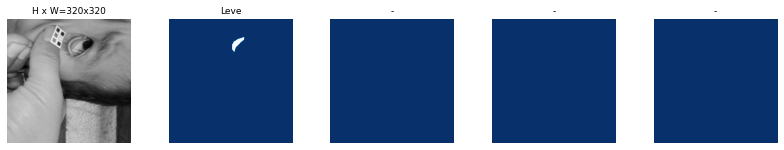

(320, 320, 3)
(320, 320, 1)
6


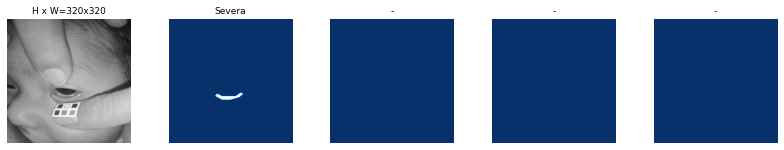

(320, 320, 3)
(320, 320, 1)
9


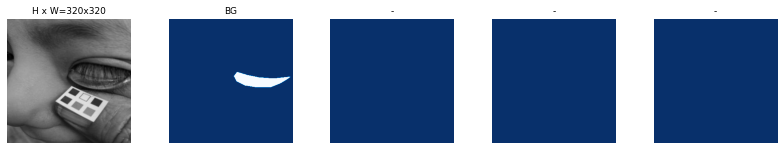

In [42]:
# Load and display random samples-Cargue y muestre muestras aleatorias
image_ids = np.random.choice(dataset_train.image_ids, 3)
 
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(image.shape)
    print(mask.shape)
    print(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [0]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

In [0]:
# Which weights to start with?¿Con qué pesos comenzar?
init_with = "coco"  # imagenet, coco, or last-iniciar pesos de coco## init_with = "coco" 
 
if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
 
# Cargar pesos entrenados en MS COCO, pero omitir capas que
# son diferentes debido a la diferente cantidad de clases
# Consulte el archivo README para obtener instrucciones sobre cómo descargar los pesos COCO
 
elif init_with == "last":
    # Load the last model you trained and continue training- carga el ultimo modelo entrenado y continua entrenando 
    model.load_weights(model.find_last(), by_name=True)

ENTRENAMIENTO

Entrena en dos etapas:

Solo las cabezas. Aquí estamos congelando todas las capas principales y entrenando solo las capas inicializadas al azar (es decir, las que no usamos pesos pre-entrenados de MS COCO). Para entrenar solo las capas de cabeza, pase capas = 'cabezas' a la función train ().

Afina todas las capas. Para este simple ejemplo no es necesario, pero lo estamos incluyendo para mostrar el proceso. Simplemente pase capas = "todas para entrenar todas las capas.

In [0]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
 
 
# Entrenar las ramas de la cabeza # Pasar capas = "cabezas" congela todas 
#las capas excepto las capas de la cabeza. También puede pasar una expresión 
#regular para seleccionar qué capas entrenar por patrón de nombre
clf=model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')
 
 
#    rpn_class_loss = RPN anchor classifier loss
#    rpn_bbox_loss = RPN bounding box loss graph
#    mrcnn_class_loss = loss for the classifier head of Mask R-CNN
#    mrcnn_bbox_loss = loss for Mask R-CNN bounding box refinement
#    mrcnn_mask_loss = mask binary cross-entropy loss for the masks head
 
# rpn_class_loss = Pérdida de clasificador de anclaje RPN
# rpn_bbox_loss = Gráfico de pérdida de cuadro delimitador RPN
# mrcnn_class_loss = pérdida para la cabeza del clasificador de la máscara R-CNN
# mrcnn_bbox_loss = pérdida por refinamiento del cuadro delimitador de máscara R-CNN
# mrcnn_mask_loss = pérdida de entropía cruzada binaria de máscara para la cabeza de máscaras


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/Colab Notebooks/SEMINARIO/maskRCNNv2/logs/fridge20200611T1252/mask_rcnn_fridge_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_c

Epoch 1/1
500/500 [==============================] - 6427s 13s/step - loss: 0.9674 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2445 - mrcnn_class_loss: 0.1036 - mrcnn_bbox_loss: 0.3234 - mrcnn_mask_loss: 0.2848 - val_loss: 0.2476 - val_rpn_class_loss: 0.0043 - val_rpn_bbox_loss: 0.0215 - val_mrcnn_class_loss: 0.0262 - val_mrcnn_bbox_loss: 0.1022 - val_mrcnn_mask_loss: 0.0934



In [0]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
 
# Afina todas las capas
# Passing layers = "all" entrena todas las capas. Tú también puedes
# pasar una expresión regular para seleccionar qué capas
# entrenar por patrón de nombre.
 
clf=model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=1, 
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /content/drive/My Drive/Colab Notebooks/SEMINARIO/maskRCNNv2/logs/fridge20200611T1252/mask_rcnn_fridge_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
re

In [0]:
from sklearn.externals import joblib
joblib.dump(clf,'modelo_entrenado.plk')

['modelo_entrenado.plk']

In [0]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
 
# Guardar pesos 
# Normalmente no es necesario porque las devoluciones de llamada se guardan después de cada época
# Descomentar para guardar manualmente
model_path = os.path.join(MODEL_DIR, "mask_rcnn_anemia4.h5")
model.keras_model.save_weights(model_path)

DETECCION 

In [44]:
class InferenceConfig(FridgeConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
inference_config = InferenceConfig()
 
# Recreate the model in inference mode
# Recrea el modelo en modo de inferencia
 
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)
 
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
#model_path = model.find_last()
 
# Obtener ruta a pesos guardados
# Establezca una ruta específica o encuentre los últimos pesos entrenados
# model_path = os.path.join (ROOT_DIR, ".h5 nombre de archivo aquí")
#model_path = model.find_last ()
 
model_path = os.path.join(MODEL_DIR, "mask_rcnn_anemia4.h5")
 
# Load trained weights- CARGAR PESOS ENTRENADOS 
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/My Drive/Colab Notebooks/SEMINARIO/maskRCNNv2/logs/mask_rcnn_anemia4.h5


original_image           shape: (320, 320, 3)         min:   18.00000  max:  255.00000  uint8
image_meta               shape: (17,)                 min:    0.00000  max:  320.00000  int64
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:  133.00000  max:  200.00000  int32
gt_mask                  shape: (320, 320, 1)         min:    0.00000  max:    1.00000  uint8


<Figure size 1440x1440 with 0 Axes>

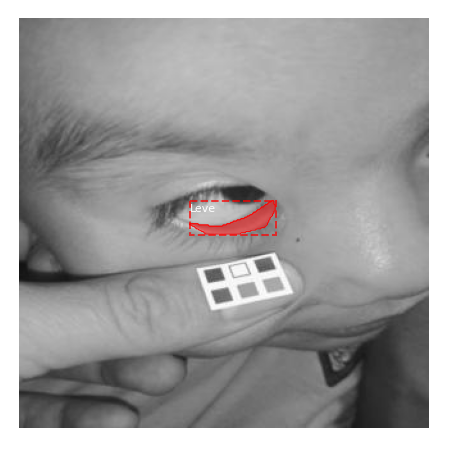

In [45]:
# Test on a random image - EVALUA UNA IMAGEN ALEATORIA 
image_id = random.choice(dataset_val.image_ids)
#image_id =3
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
 
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
plt.figure(figsize=(20,20))
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (320, 320, 3)         min:   18.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (1, 17)               min:    0.00000  max:  320.00000  int64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


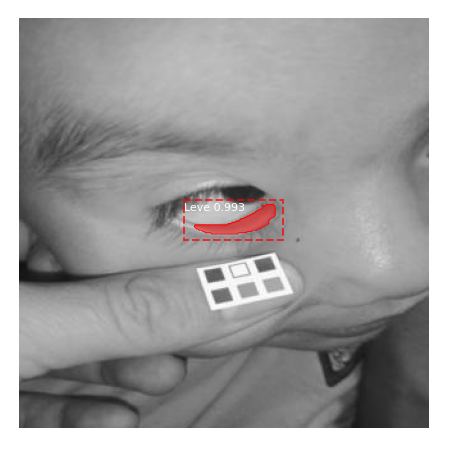

In [46]:
 original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                            image_id, use_mini_mask=False)
 
results = model.detect([original_image], verbose=1);
 
r = results[0];
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [47]:
#EVALUACION 
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 8)##se remplazó 120 por 8 
APs = []
for image_id in image_ids:
    # Load image and ground truth data-
    # Cargar imagen y datos de verdad del terreno
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    print(r)
 
     # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

{'rois': array([[168,  85, 194, 160]], dtype=int32), 'class_ids': array([4], dtype=int32), 'scores': array([0.9874455], dtype=float32), 'masks': array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])}
{'rois': array([[185, 110, 204, 185]], dtype=int32), 'class_ids': array([1], dtype=int32), 'scores': array([0.9959099], dtype=float32), 'ma

In [0]:
import matplotlib.lines as lines
from matplotlib.patches import Polygon
import IPython.display
import os
from PIL import Image, ImageDraw, ImageFont,ImageOps
 
def save_image(image, image_name, boxes, masks, class_ids, scores, class_names, filter_classs_names=None,
               scores_thresh=0.1, save_dir=None, mode=0, export_options=None):
    """
        image: image array
        image_name: image name
        boxes: [num_instance, (y1, x1, y2, x2, class_id)] in image coordinates.
        masks: [num_instances, height, width]
        class_ids: [num_instances]
        scores: confidence scores for each box
        class_names: list of class names of the dataset
        filter_classs_names: (optional) list of class names we want to draw
        scores_thresh: (optional) threshold of confidence scores
        save_dir: (optional) the path to store image
        mode: (optional) select the result which you want
                mode = 0 , save image with bbox,class_name,score and mask;
                mode = 1 , save image with bbox,class_name and score;
                mode = 2 , save image with class_name,score and mask;
                mode = 3 , save mask with black background;
    """
    mode_list = [0, 1, 2, 3]
    assert mode in mode_list, "mode's value should in mode_list %s" % str(mode_list)
 
    if save_dir is None:
        save_dir = os.path.join(os.getcwd(), "Marcasm2")
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
 
    useful_mask_indices = []
 
    N = boxes.shape[0]
    if not N:
        print("\n*** No instances in image %s to draw *** \n" % (image_name))
        return
    else:
        assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]
 
    for i in range(N):
        # filter
        class_id = class_ids[i]
        score = scores[i] if scores is not None else None
        if score is None or score < scores_thresh:
            continue
 
        label = class_names[class_id]
        if (filter_classs_names is not None) and (label not in filter_classs_names):
            continue
 
        if not np.any(boxes[i]):
            # Skip this instance. Has no bbox. Likely lost in image cropping.
            continue
 
        useful_mask_indices.append(i)
 
    if len(useful_mask_indices) == 0:
        print("\n*** No instances in image %s to draw *** \n" % (image_name))
        return
 
    colors = random_colors(len(useful_mask_indices))
 
    if mode != 3:
        masked_image = image.astype(np.uint8).copy()
    else:
        #masked_image = 0*np.ones(image.shape).astype(np.uint8) #BackgroundColor
        masked_image = 0*np.ones(image.shape).astype(np.uint8) #BackgroundColor
 
    if mode != 1:
        for index, value in enumerate(useful_mask_indices):
            masked_image = apply_mask(masked_image, masks[:, :, value], colors[index])
 
    masked_image = Image.fromarray(masked_image)
 
    if mode == 3:
        area = (0, 0, 340, 340)
        cropped_img = masked_image.crop(area)
        cropped_img.save(os.path.join(save_dir, '%s.png' % (image_name)))
        return
 
    draw = ImageDraw.Draw(masked_image)
    colors = np.array(colors).astype(int) * 255
 
    for index, value in enumerate(useful_mask_indices):
        class_id = class_ids[value]
        score = scores[value]
        label = class_names[class_id]
 
        y1, x1, y2, x2 = boxes[value]
        if mode != 2:
            color = tuple(colors[index])
            draw.rectangle((x1, y1, x2, y2), outline=color)
        
        # Label 
        if export_options=="printLabel1":
            font = ImageFont.truetype('arial.ttf', 22)
            draw.text((x1, y1), "%s %f" % (label, score), (255, 255, 255), font)
    
    area = (0, 0, 340, 340)
    cropped_img = masked_image.crop(area)
    cropped_img.save(os.path.join(save_dir, '%s.png' % (image_name)))
def random_colors(N):
    np.random.seed(1)
    colors = [tuple(255 * np.array([1,1,1])) for _ in range(N)]
    #colors = [tuple(255 * np.random.rand(3)) for _ in range(N)]
    return colors
def apply_mask(image, mask, color, alpha=0.7):#def apply_mask(image, mask, color, alpha=0.5):
    """apply mask to image"""
    for n, c in enumerate(color):
        image[:, :, n] = np.where(
            mask == 1,
            image[:, :, n] * (1 - alpha) + alpha * c,
            image[:, :, n]
        )
    return image

In [0]:
#for exportCount in range(10):
#    filenamexport='im20xG1_1'+str(exportCount)
#    save_image(original_image, filenamexport, r['rois'], r['masks'], r["class_ids"], r["scores"], dataset_val.class_names,filter_classs_names=None,
#                   scores_thresh=0.1, save_dir=None, mode=3,export_options="printLabels")

 # Guardar imagenes de las Marcas



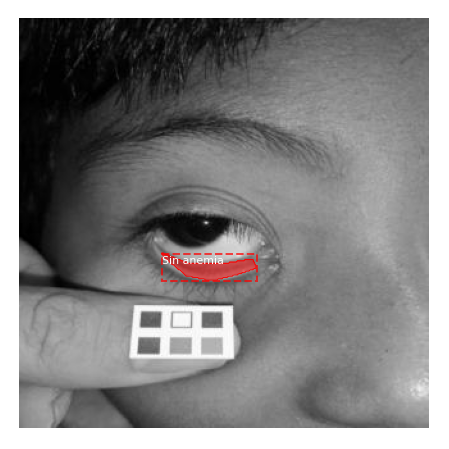

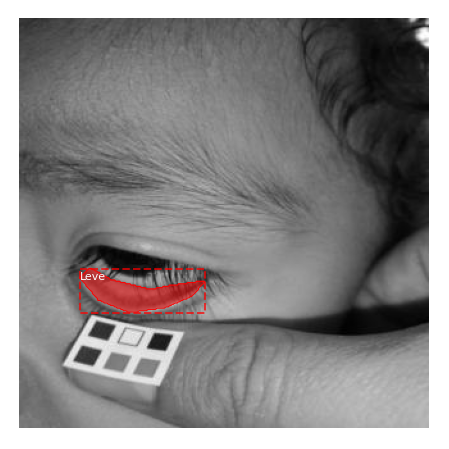

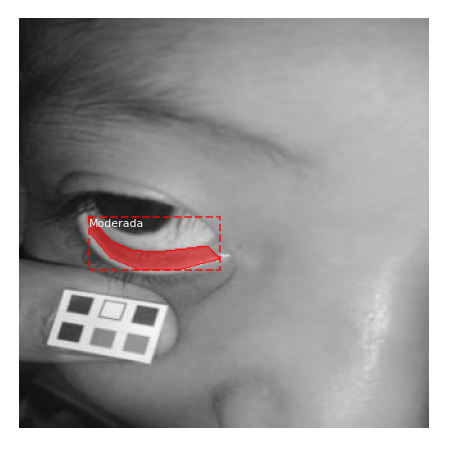

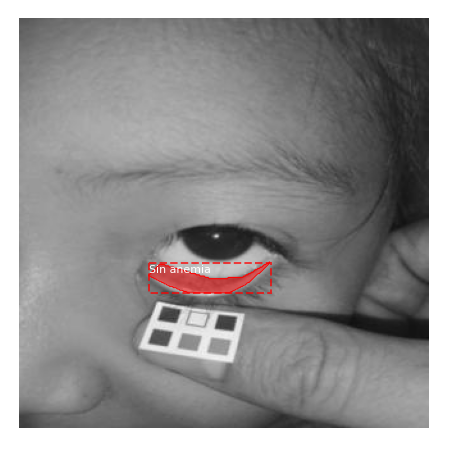

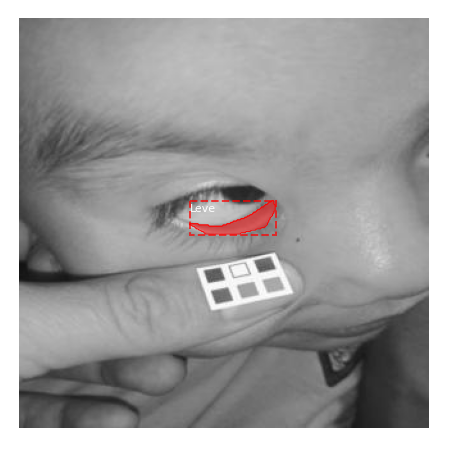

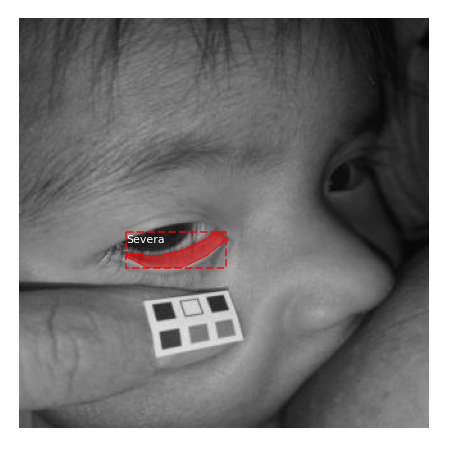

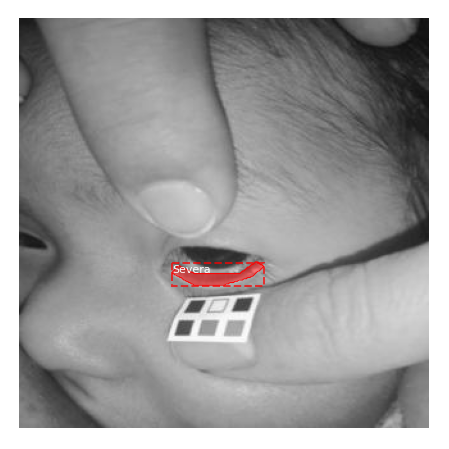

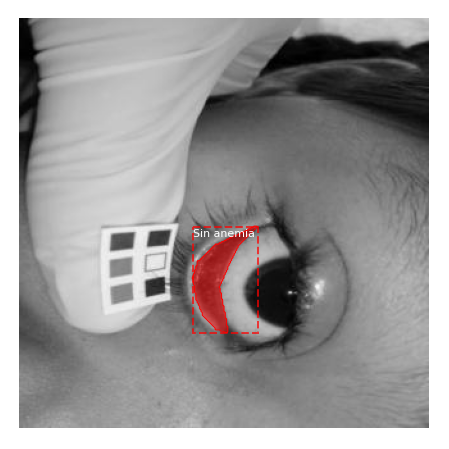

In [49]:

for exportCount in range(8):#35
    image_id =exportCount;
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False);

    #log("original_image", original_image);
    #log("image_meta", image_meta);
    #log("gt_class_id", gt_class_id);
    #log("gt_bbox", gt_bbox);
    #log("gt_mask", gt_mask);

    
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset_val.class_names, figsize=(8, 8))
        
    filenamexport1='im20xG1MarkedBN_'+str(exportCount+1).zfill(3)
    save_image(original_image, filenamexport1, gt_bbox, gt_mask, gt_class_id, gt_class_id, dataset_val.class_names,filter_classs_names=None,
                   scores_thresh=0.1, save_dir=None, mode=3,export_options="printLabel1")
    
    results = model.detect([original_image], verbose=0);
    r = results[0];
    #visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
    #                        dataset_val.class_names, r['scores'], ax=get_ax())
    
    filenamexport2='im20xG1DetectedBN_'+str(exportCount+1).zfill(3)
    save_image(original_image, filenamexport2, r['rois'], r['masks'], r["class_ids"], r["scores"], dataset_val.class_names,filter_classs_names=None,
                   scores_thresh=0.1, save_dir=None, mode=3,export_options="printLabel1")
    

import sys
from PIL import Image

imagesRec = map(Image.open, ['Marcasm3La/im20xG1Detected_001.png'])
widths, heights = zip(*(i.size for i in imagesRec))

total_width = sum(widths)
max_height = max(heights)

new_im = Image.new('RGB', (total_width, max_height))

x_offset = 0
for im in imagesRec:
    print(im)
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]

new_im.show()

 # Guardar imagenes de las detecciones


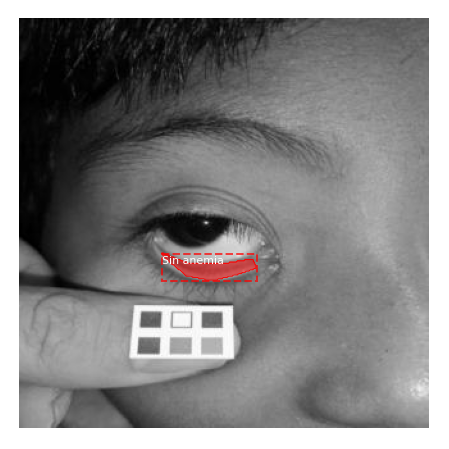

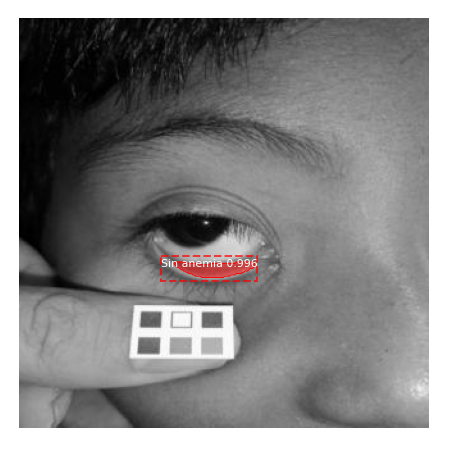

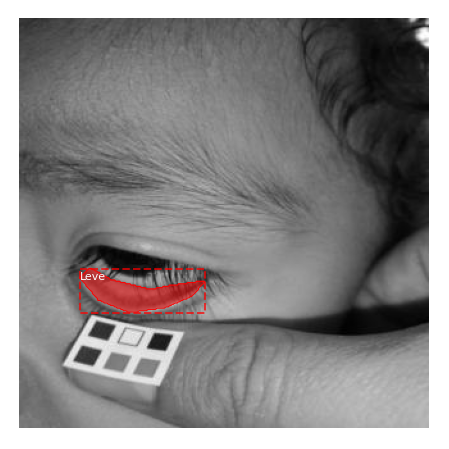

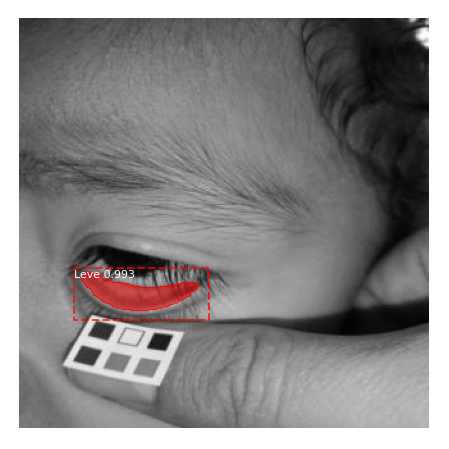

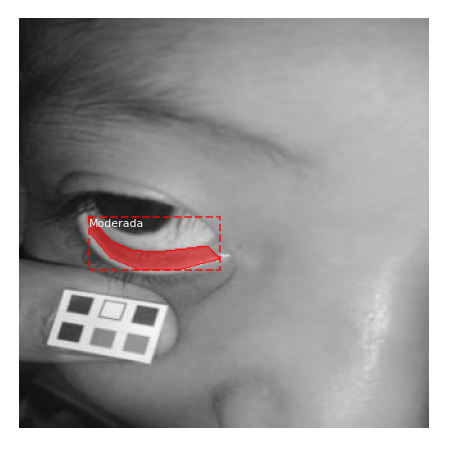

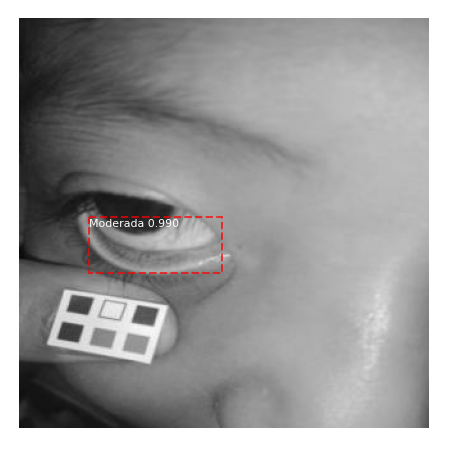

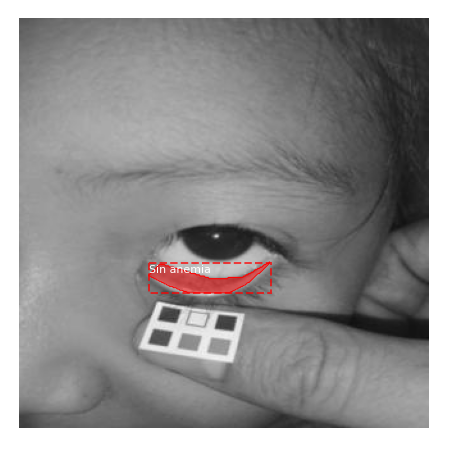

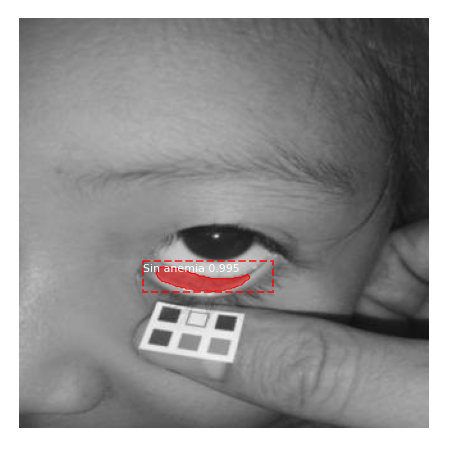

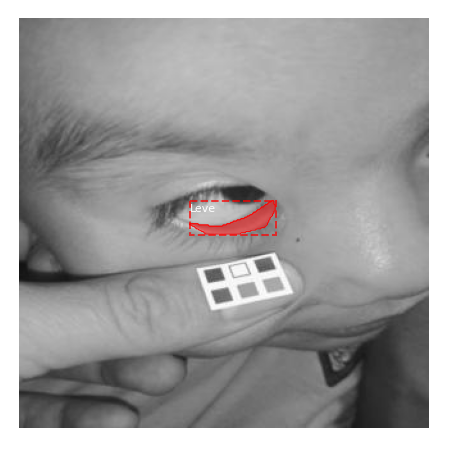

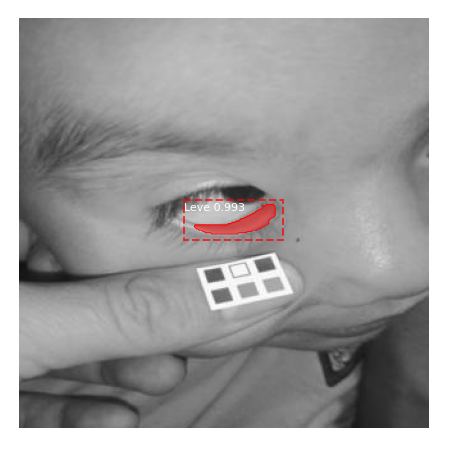

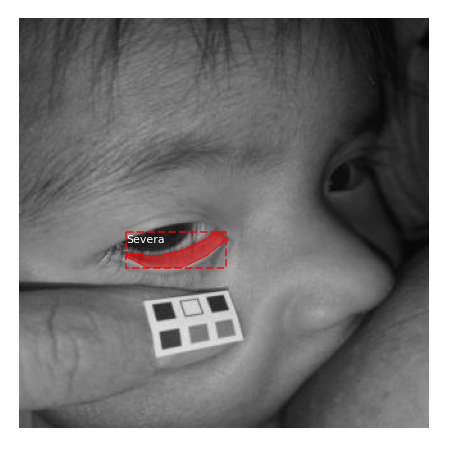

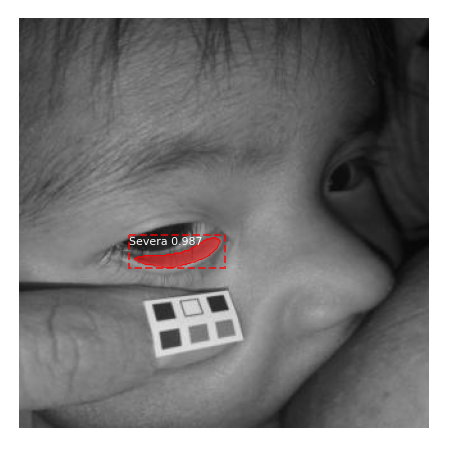

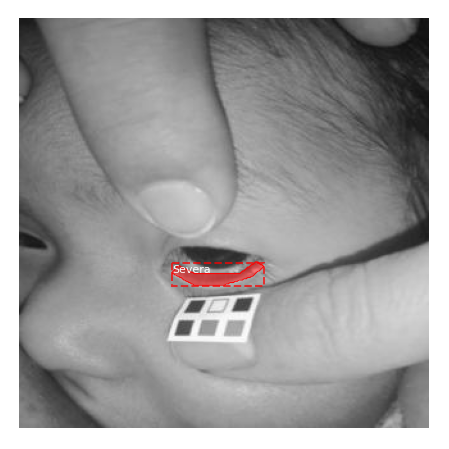

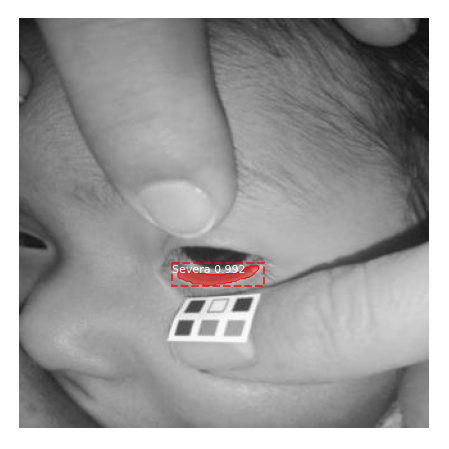

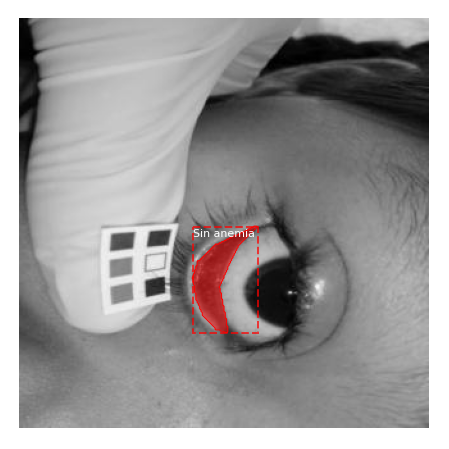

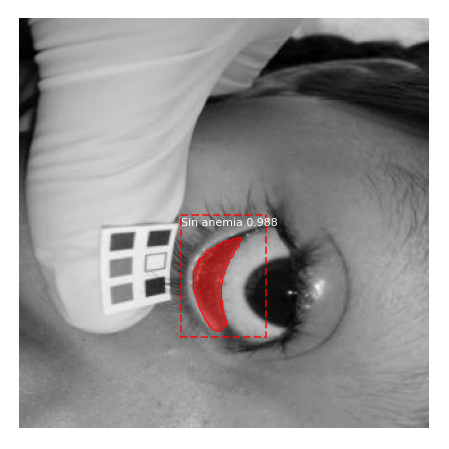

In [131]:

for exportCount in range(8):#35
    image_id =exportCount;
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False);

    #log("original_image", original_image);
    #log("image_meta", image_meta);
    #log("gt_class_id", gt_class_id);
    #log("gt_bbox", gt_bbox);
    #log("gt_mask", gt_mask);

    
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset_val.class_names, figsize=(8, 8))
        
    filenamexport1='Marked'+str(exportCount+1).zfill(3)
    save_image(original_image, filenamexport1, gt_bbox, gt_mask, gt_class_id, gt_class_id, dataset_val.class_names,filter_classs_names=None,
                   scores_thresh=0.1, save_dir=None, mode=2,export_options="printLabel")
    
    results = model.detect([original_image], verbose=0);
    r = results[0];
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())
    
    filenamexport2='Detected'+str(exportCount+1).zfill(3)
    save_image(original_image, filenamexport2, r['rois'], r['masks'], r["class_ids"], r["scores"], dataset_val.class_names,filter_classs_names=None,
                   scores_thresh=0.1, save_dir=None, mode=2,export_options="printLabel")
    

    

 # Guardar imagen completa con las detecciones

In [135]:
import numpy as np
import PIL
from PIL import Image


list_im=[None] * 3 ####6
contadorIterVer=0
for iteracionesverticales in range(1,2,1): ##in range(1,36,6)
    contadorIterVer+=1
    for nombreImagenes in range(3):#in range(6):
        list_im[nombreImagenes]='/content/Marcasm2/Detected00'+ str(nombreImagenes+iteracionesverticales)+".png"
    print(list_im)


    imgs    = [ PIL.Image.open(i) for i in list_im ]
    # pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
    min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]

    imgs_comb = np.vstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
    imgs_comb = PIL.Image.fromarray( imgs_comb)
    #imgs_comb = Image.fromarray( imgs_comb)
    imgs_comb.save( 'Marcasm3LaN/Detected20xG1_vertical'+str(contadorIterVer)+'.png' )

        



['/content/Marcasm2/Detected001.png', '/content/Marcasm2/Detected002.png', '/content/Marcasm2/Detected003.png']


In [136]:
import numpy as np
import PIL
from PIL import Image


list_im=[None] * 3 ####6
contadorIterVer=0
for iteracionesverticales in range(1,2,1): ##in range(1,36,6)
    contadorIterVer+=2
    for nombreImagenes in range(3):#in range(6):
        list_im[nombreImagenes]='/content/Marcasm2/im20xG1DetectedBN_00'+ str(nombreImagenes+iteracionesverticales)+".png"
    print(list_im)


    imgs    = [ PIL.Image.open(i) for i in list_im ]
    # pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
    min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]

    imgs_comb = np.vstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
    imgs_comb = PIL.Image.fromarray( imgs_comb)
    #imgs_comb = Image.fromarray( imgs_comb)
    imgs_comb.save( 'Marcasm3LaN/Detected20xG1_vertical'+str(contadorIterVer)+'.png' )

        



['/content/Marcasm2/im20xG1DetectedBN_001.png', '/content/Marcasm2/im20xG1DetectedBN_002.png', '/content/Marcasm2/im20xG1DetectedBN_003.png']


In [114]:
import numpy as np
import PIL
from PIL import Image

list_im = ['/content/Marcasm2/im20xG1DetectedBN_001.png', '/content/Marcasm2/im20xG1DetectedBN_002.png', '/content/Marcasm2/im20xG1DetectedBN_003.png']
imgs    = [ PIL.Image.open(i) for i in list_im ]
# pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]
imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )

# save that beautiful picture
imgs_comb = PIL.Image.fromarray( imgs_comb)
imgs_comb.save( 'Trifecta.jpg' )   
print(imgs_comb) 

# for a vertical stacking it is simple: use vstack
imgs_comb = np.vstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )

imgs_comb = PIL.Image.fromarray( imgs_comb)
imgs_comb.save( 'Trifecta_vertical.jpg' )

<PIL.Image.Image image mode=RGB size=1020x340 at 0x7F47F2F8E908>


In [137]:
list_im=[None] * 2 ##6
for nombreImagenes in range(2): #in range(6)
    list_im[nombreImagenes]='Marcasm3LaN/Detected20xG1_vertical'+str(nombreImagenes+1)+'.png'
print(list_im)

imgs    = [ Image.open(i) for i in list_im ]
# pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]

imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
imgs_comb = Image.fromarray( imgs_comb)
imgs_comb.save( 'Marcasm3LaN/Detectedresizedim20xG1.jpg' )    

['Marcasm3LaN/Detected20xG1_vertical1.png', 'Marcasm3LaN/Detected20xG1_vertical2.png']


 # Guardar imagen completa con las Marcas


In [138]:
import numpy as np
import PIL
from PIL import Image


list_im=[None] * 3 ####6
contadorIterVer=0
for iteracionesverticales in range(1,2,1): ##in range(1,36,6)
    contadorIterVer+=1
    for nombreImagenes in range(3):#in range(6):
        list_im[nombreImagenes]='/content/Marcasm2/Marked00'+ str(nombreImagenes+iteracionesverticales)+".png"
    print(list_im)


    imgs    = [ PIL.Image.open(i) for i in list_im ]
    # pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
    min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]

    imgs_comb = np.vstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
    imgs_comb = PIL.Image.fromarray( imgs_comb)
    #imgs_comb = Image.fromarray( imgs_comb)
    
    imgs_comb.save( 'Marcasm3LaN/Marked20xG1_vertical'+str(contadorIterVer)+'.png' )

['/content/Marcasm2/Marked001.png', '/content/Marcasm2/Marked002.png', '/content/Marcasm2/Marked003.png']


In [139]:
import numpy as np
import PIL
from PIL import Image


list_im=[None] * 3 ####6
contadorIterVer=0
for iteracionesverticales in range(1,2,1): ##in range(1,36,6)
    contadorIterVer+=2
    for nombreImagenes in range(3):#in range(6):
        list_im[nombreImagenes]='/content/Marcasm2/im20xG1MarkedBN_00'+ str(nombreImagenes+iteracionesverticales)+".png"
    print(list_im)


    imgs    = [ PIL.Image.open(i) for i in list_im ]
    # pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
    min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]

    imgs_comb = np.vstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
    imgs_comb = PIL.Image.fromarray( imgs_comb)
    #imgs_comb = Image.fromarray( imgs_comb)
    
    imgs_comb.save( 'Marcasm3LaN/Marked20xG1_vertical'+str(contadorIterVer)+'.png' )

['/content/Marcasm2/im20xG1MarkedBN_001.png', '/content/Marcasm2/im20xG1MarkedBN_002.png', '/content/Marcasm2/im20xG1MarkedBN_003.png']


In [140]:
list_im=[None] * 2#6
for nombreImagenes in range(2):#in range(6):
    list_im[nombreImagenes]='Marcasm3LaN/Marked20xG1_vertical'+str(nombreImagenes+1)+'.png'
print(list_im)

imgs    = [ Image.open(i) for i in list_im ]
# pick the image which is the smallest, and resize the others to match it (can be arbitrary image shape here)
min_shape = sorted( [(np.sum(i.size), i.size ) for i in imgs])[0][1]

imgs_comb = np.hstack( (np.asarray( i.resize(min_shape) ) for i in imgs ) )
imgs_comb = Image.fromarray( imgs_comb)
imgs_comb.save( 'Marcasm3LaN/Markedresizedim20xG1.jpg' )    

['Marcasm3LaN/Marked20xG1_vertical1.png', 'Marcasm3LaN/Marked20xG1_vertical2.png']
